[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davemlz/eemont/blob/master/docs/tutorials/014-Time-Series-By-Regions-Pandas.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/davemlz/eemont/blob/master/docs/tutorials/014-Time-Series-By-Regions-Pandas.ipynb)
[![Open in Planetary Computer](https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft)](https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/davemlz/eemont&urlpath=lab/tree/eemont/docs/tutorials/014-Time-Series-By-Regions-Pandas.ipynb&branch=master)

# Time Series By Regions (with Conversion to Pandas and Visualization with Seaborn)

_Tutorial created by **David Montero Loaiza**_: [GitHub](https://github.com/davemlz) | [Twitter](https://twitter.com/dmlmont)

- GitHub Repo: [https://github.com/davemlz/eemont](https://github.com/davemlz/eemont)
- PyPI link: [https://pypi.org/project/eemont/](https://pypi.org/project/eemont/)
- Conda-forge: [https://anaconda.org/conda-forge/eemont](https://anaconda.org/conda-forge/eemont)
- Documentation: [https://eemont.readthedocs.io/](https://eemont.readthedocs.io/)
- More tutorials: [https://github.com/davemlz/eemont/tree/master/docs/tutorials](https://github.com/davemlz/eemont/tree/master/docs/tutorials)

## Let's start!

If required, please uncomment:

In [1]:
#!pip install eemont
#!pip install geemap

Import the required packges.

In [2]:
import ee, eemont, geemap
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Authenticate and Initialize Earth Engine and geemap.

In [3]:
Map = geemap.Map()

Let's use some center-pivot crops in Egypt:

In [4]:
pivots = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([27.724856,26.485040]).buffer(400),{'pivot':0}),
    ee.Feature(ee.Geometry.Point([27.719427,26.478505]).buffer(400),{'pivot':1}),
    ee.Feature(ee.Geometry.Point([27.714185,26.471802]).buffer(400),{'pivot':2})    
])

Let's pre-process and process our image collection:

In [5]:
L8 = (ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
      .filterBounds(pivots)
      .maskClouds()
      .scaleAndOffset()
      .spectralIndices(['EVI','GNDVI']))

## Time Series By Regions

Let's get the L8 time series for our buffer. Checklist:

- Image Collection: The Landsat 8 collection.
- Bands to use for the time series: GNDVI and EVI.
- Feature Collection: Our center-pivot crops.
- Statistics to compute: Mean and Median.
- Scale: 30 m.

In [6]:
ts = L8.getTimeSeriesByRegions(collection = pivots,
                               bands = ['EVI','GNDVI'],
                               reducer = [ee.Reducer.mean(),ee.Reducer.median()],
                               scale = 30)

## Conversion to Pandas

The time series is retrieved as a feature collection. To convert it to a pandas dataframe we'll use `geemap` (This may take a little bit):

In [7]:
tsPandas = geemap.ee_to_pandas(ts)

Let's check our pandas data frame:

In [8]:
tsPandas

,date,pivot,EVI,reducer,GNDVI
0,2013-04-01T08:40:36,0,0.585979,mean,0.648333
1,2013-04-01T08:40:36,1,0.131134,mean,0.312830
2,2013-04-01T08:40:36,2,0.642244,mean,0.697033
3,2013-04-11T08:40:46,0,0.290635,mean,0.482938
4,2013-04-11T08:40:46,1,0.099826,mean,0.297480
...,...,...,...,...,...
1141,2021-09-08T08:37:40,1,0.327657,median,0.507243
1142,2021-09-08T08:37:40,2,0.289696,median,0.451613
1143,2021-10-10T08:37:49,0,0.154731,median,0.366600
1144,2021-10-10T08:37:49,1,0.446784,median,0.630140


What can we see here?

- The values for each band (GNDVI and EVI) are in separated columns.
- There are some -9999 values in the GNDVI and EVI columns. These values represent the NA values (e.g. Clouds or shadows). The -9999 can be changed by modifying the `naValue` parameter in the `getTimeSeriesByRegion` method (e.g. `naValue = -10000`).
- Multiple reducers can be used. In the output dataframe they are specified by a single column named `reducer`: mean, median.
- The date is a string that needs to be converted to a date data type.
- The attributes of the original feature collection are attached to the data frame: `pivot`.

Given this, let's curate our data frame!

First, let's get rid of the -9999 value:

In [9]:
tsPandas[tsPandas == -9999] = np.nan

And now, let's convert the date to a date data type:

In [10]:
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)

We can also gather the GNDVI and EVI columns into a single column to make the data frame more 'tidy-er' (This is optional):

In [11]:
tsPandas = pd.melt(tsPandas,
                   id_vars = ['reducer','date','pivot'],
                   value_vars = ['GNDVI','EVI'],
                   var_name = 'Index',
                   value_name = 'Value')

Let's check our curated data frame:

In [12]:
tsPandas

,reducer,date,pivot,Index,Value
0,mean,2013-04-01 08:40:36,0,GNDVI,0.648333
1,mean,2013-04-01 08:40:36,1,GNDVI,0.312830
2,mean,2013-04-01 08:40:36,2,GNDVI,0.697033
3,mean,2013-04-11 08:40:46,0,GNDVI,0.482938
4,mean,2013-04-11 08:40:46,1,GNDVI,0.297480
...,...,...,...,...,...
2287,median,2021-09-08 08:37:40,1,EVI,0.327657
2288,median,2021-09-08 08:37:40,2,EVI,0.289696
2289,median,2021-10-10 08:37:49,0,EVI,0.154731
2290,median,2021-10-10 08:37:49,1,EVI,0.446784


## Visualization

Now, let's visualize our time series using `seaborn`:

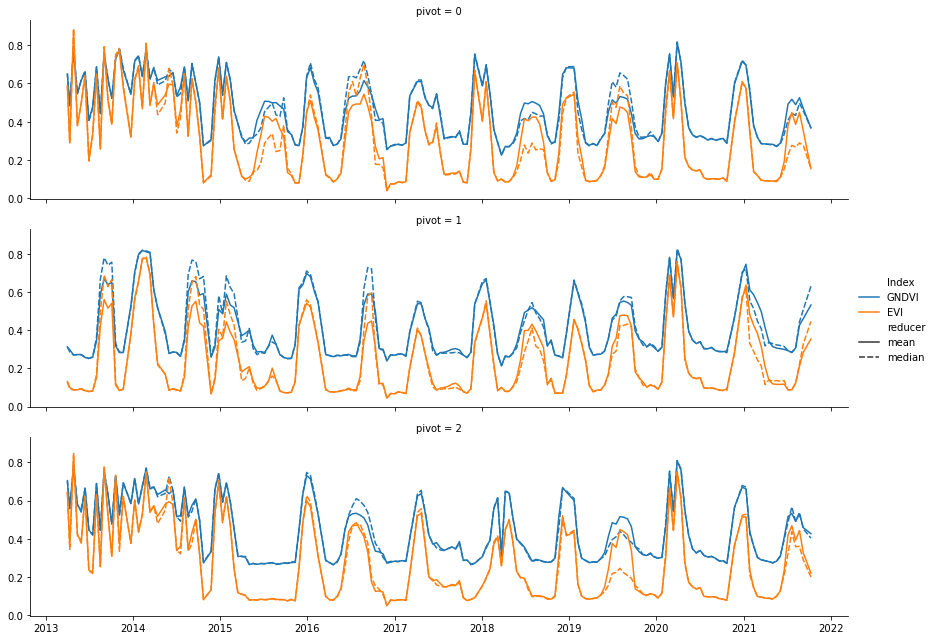

In [13]:
g = sns.FacetGrid(tsPandas,row = 'pivot',height = 3,aspect = 4)
g.map_dataframe(sns.lineplot,x = 'date',y = 'Value',hue = 'Index',style = 'reducer')
g.add_legend()